In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("nyc-property-sales.csv")

/var/folders/wk/w4dq25x94cg_26_p83q6tnlh0000gn/T/ipykernel_3165/165743856.py:1: DtypeWarning: Columns (0,4,5,6,10,11,12,13,14,15,16,17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("nyc-property-sales.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018049 entries, 0 to 2018048
Data columns (total 21 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   BOROUGH                         object
 1   NEIGHBORHOOD                    object
 2   BUILDING CLASS CATEGORY         object
 3   TAX CLASS AT PRESENT            object
 4   BLOCK                           object
 5   LOT                             object
 6   EASE-MENT                       object
 7   BUILDING CLASS AT PRESENT       object
 8   ADDRESS                         object
 9   APARTMENT NUMBER                object
 10   ZIP CODE                       object
 11  RESIDENTIAL UNITS               object
 12  COMMERCIAL UNITS                object
 13  TOTAL UNITS                     object
 14  LAND SQUARE FEET                object
 15  GROSS SQUARE FEET               object
 16  YEAR BUILT                      object
 17  TAX CLASS AT TIME OF SALE       object
 18  BU

In [4]:
df["SALE PRICE"].value_counts()

SALE PRICE
0           591822
10           16208
450000       10111
400000        9892
550000        9307
             ...  
62400000         1
4858351          1
9263015          1
38595759         1
94136            1
Name: count, Length: 114422, dtype: int64

In [5]:
df["SALE PRICE"] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

In [6]:
df = df[df["SALE PRICE"] > 0]

In [7]:
df[df["SALE PRICE"]>0]

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,374,46,NaN,A4,347 EAST 4TH STREET,NaN,...,1.0,0.0,1.0,2116.0,4400.0,1900.0,1,A4,399000.0,2022-09-29 00:00:00
1,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377,1,NaN,S2,110 AVENUE C,NaN,...,2.0,1.0,3.0,1502.0,2790.0,1901.0,1,S2,2999999.0,2022-09-15 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,16,NaN,C1,326 EAST 4TH STREET,NaN,...,10.0,0.0,10.0,2204.0,8625.0,1899.0,2,C1,16800000.0,2022-08-04 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,17,NaN,C1,328 EAST 4TH STREET,NaN,...,10.0,0.0,10.0,2204.0,8625.0,1900.0,2,C1,16800000.0,2022-08-04 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,"719 EAST SIXTH STREET, 1B",NaN,...,20.0,0.0,20.0,2302.0,9750.0,1900.0,2,C4,158822.0,2022-09-27 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018044,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1,6970,84,NaN,A1,N/A LENEVAR AVENUE,NaN,...,1.0,0.0,1.0,2603.0,0.0,2022.0,1,V0,1116638.0,2022-12-19 00:00:00
2018045,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1,6970,85,NaN,A1,N/A LENEVAR AVENUE,NaN,...,1.0,0.0,1.0,2551.0,0.0,NaN,1,V0,1116638.0,2022-12-19 00:00:00
2018046,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1B,6970,86,NaN,V0,N/A LENEVAR AVENUE,NaN,...,0.0,0.0,0.0,2597.0,0.0,2023.0,1,V0,1116638.0,2022-12-19 00:00:00
2018047,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1B,6970,87,NaN,V0,96 LENEVAR AVENUE,NaN,...,0.0,0.0,0.0,2644.0,0.0,2023.0,1,V0,1116638.0,2022-12-19 00:00:00


PLUTO

In [8]:
df2 = pd.read_csv("nyc_pluto_24v4_1_csv/pluto_24v4_1.csv")

/var/folders/wk/w4dq25x94cg_26_p83q6tnlh0000gn/T/ipykernel_3165/2914519796.py:1: DtypeWarning: Columns (21,22,24,26,28,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("nyc_pluto_24v4_1_csv/pluto_24v4_1.csv")


In [9]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,374,46,NaN,A4,347 EAST 4TH STREET,NaN,...,1.0,0.0,1.0,2116.0,4400.0,1900.0,1,A4,399000.0,2022-09-29 00:00:00
1,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377,1,NaN,S2,110 AVENUE C,NaN,...,2.0,1.0,3.0,1502.0,2790.0,1901.0,1,S2,2999999.0,2022-09-15 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,16,NaN,C1,326 EAST 4TH STREET,NaN,...,10.0,0.0,10.0,2204.0,8625.0,1899.0,2,C1,16800000.0,2022-08-04 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,17,NaN,C1,328 EAST 4TH STREET,NaN,...,10.0,0.0,10.0,2204.0,8625.0,1900.0,2,C1,16800000.0,2022-08-04 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,"719 EAST SIXTH STREET, 1B",NaN,...,20.0,0.0,20.0,2302.0,9750.0,1900.0,2,C4,158822.0,2022-09-27 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018044,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1,6970,84,NaN,A1,N/A LENEVAR AVENUE,NaN,...,1.0,0.0,1.0,2603.0,0.0,2022.0,1,V0,1116638.0,2022-12-19 00:00:00
2018045,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1,6970,85,NaN,A1,N/A LENEVAR AVENUE,NaN,...,1.0,0.0,1.0,2551.0,0.0,NaN,1,V0,1116638.0,2022-12-19 00:00:00
2018046,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1B,6970,86,NaN,V0,N/A LENEVAR AVENUE,NaN,...,0.0,0.0,0.0,2597.0,0.0,2023.0,1,V0,1116638.0,2022-12-19 00:00:00
2018047,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1B,6970,87,NaN,V0,96 LENEVAR AVENUE,NaN,...,0.0,0.0,0.0,2644.0,0.0,2023.0,1,V0,1116638.0,2022-12-19 00:00:00


In [10]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', ' ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [11]:
df2

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,BK,7604,47,314.0,3075200.0,3.075200e+10,752.00,1004.0,22.0,45.0,...,NaN,NaN,1,NaN,NaN,24v4.1,NaN,40.625779,-73.953658,NaN
1,BK,1304,1,309.0,3032300.0,3.032300e+10,323.00,3002.0,17.0,35.0,...,3.013040e+09,10/20/1989,1,NaN,NaN,24v4.1,NaN,40.664671,-73.956901,NaN
2,BK,1304,58,309.0,3032300.0,3.032300e+10,323.00,3001.0,17.0,35.0,...,NaN,NaN,1,NaN,NaN,24v4.1,NaN,40.665104,-73.955675,NaN
3,BK,1294,1,309.0,3032500.0,3.032500e+10,325.00,3000.0,17.0,35.0,...,3.012940e+09,02/27/1989,1,NaN,NaN,24v4.1,NaN,40.666423,-73.958074,NaN
4,BK,1302,1,309.0,3032500.0,3.032500e+10,325.00,3001.0,17.0,35.0,...,NaN,NaN,1,NaN,NaN,24v4.1,NaN,40.665062,-73.958101,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858637,SI,6901,322,503.0,5020803.0,5.020803e+10,208.03,3011.0,31.0,51.0,...,NaN,NaN,3,NaN,NaN,24v4.1,NaN,40.526255,-74.205792,NaN
858638,BX,5891,1624,208.0,2033700.0,2.033700e+10,337.00,1001.0,10.0,11.0,...,NaN,NaN,1,NaN,NaN,24v4.1,NaN,40.912689,-73.901004,NaN
858639,BK,8126,64,318.0,3097000.0,3.097000e+10,970.00,2002.0,18.0,42.0,...,NaN,NaN,3,NaN,NaN,24v4.1,NaN,40.647118,-73.909108,NaN
858640,BX,5103,8900,212.0,2041400.0,2.041400e+10,414.00,4008.0,11.0,11.0,...,NaN,NaN,3,NaN,NaN,24v4.1,NaN,40.906355,-73.852509,NaN


In [12]:
df2.columns

Index(['borough', 'block', 'lot', 'cd', 'bct2020', 'bctcb2020', 'ct2010',
       'cb2010', 'schooldist', 'council', 'zipcode', 'firecomp', 'policeprct',
       'healthcenterdistrict', 'healtharea', 'sanitboro', 'sanitdistrict',
       'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3',
       'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3',
       'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements',
       'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea',
       'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea',
       'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres',
       'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext',
       'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland',
       'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2',
       'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar',
       'borocode', 'bbl', 'cond

In [13]:
df2["borough"].value_counts()

borough
QN    324625
BK    276404
SI    125496
BX     89530
MN     42587
Name: count, dtype: int64

In [14]:
borough_map = {
    'MN': 1, 'BX': 2, 'BK': 3, 'QN': 4, 'SI': 5
}

In [15]:
df2['borough'] = df2['borough'].map(borough_map)

In [16]:
df_renamed = df.rename(columns={"BOROUGH": "borough", "BLOCK": "block", "LOT": "lot"})

In [17]:
df_merged = df_renamed.merge(df2, on=['borough', 'block', 'lot'], how='left')
df_merged

,borough,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,block,lot,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,374,46,NaN,A4,347 EAST 4TH STREET,NaN,...,NaN,NaN,1.0,NaN,NaN,24v4.1,NaN,40.721716,-73.978275,NaN
1,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377,1,NaN,S2,110 AVENUE C,NaN,...,NaN,NaN,1.0,NaN,1.0,24v4.1,NaN,40.724184,-73.978458,NaN
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,16,NaN,C1,326 EAST 4TH STREET,NaN,...,NaN,NaN,1.0,NaN,NaN,24v4.1,NaN,40.721673,-73.979299,NaN
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,17,NaN,C1,328 EAST 4TH STREET,NaN,...,NaN,NaN,1.0,NaN,NaN,24v4.1,NaN,40.721642,-73.979227,NaN
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,"719 EAST SIXTH STREET, 1B",NaN,...,NaN,NaN,1.0,NaN,1.0,24v4.1,NaN,40.723270,-73.978191,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417560,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1,6970,84,NaN,A1,N/A LENEVAR AVENUE,NaN,...,5.069700e+09,08/02/2021,1.0,NaN,NaN,24v4.1,NaN,40.538983,-74.209426,NaN
1417561,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1,6970,85,NaN,A1,N/A LENEVAR AVENUE,NaN,...,5.069700e+09,08/02/2021,1.0,NaN,NaN,24v4.1,NaN,40.538917,-74.209408,NaN
1417562,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1B,6970,86,NaN,V0,N/A LENEVAR AVENUE,NaN,...,5.069700e+09,08/02/2021,1.0,NaN,NaN,24v4.1,NaN,40.538851,-74.209390,NaN
1417563,5,WOODROW,05 TAX CLASS 1 VACANT LAND,1B,6970,87,NaN,V0,96 LENEVAR AVENUE,NaN,...,5.069700e+09,08/02/2021,1.0,NaN,NaN,24v4.1,NaN,40.538785,-74.209375,NaN


In [18]:
df_merged["version"].value_counts()

version
24v4.1    1018815
Name: count, dtype: int64

In [19]:
def to_lowercase_columns(dataframe):
    return dataframe.rename(columns=str.lower)

# Apply the function to df
df = to_lowercase_columns(df)

# Display the first few rows to verify the changes
df.head()

,borough,neighborhood,building class category,tax class at present,block,lot,ease-ment,building class at present,address,apartment number,...,residential units,commercial units,total units,land square feet,gross square feet,year built,tax class at time of sale,building class at time of sale,sale price,sale date
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,374,46,NaN,A4,347 EAST 4TH STREET,NaN,...,1.0,0.0,1.0,2116.0,4400.0,1900.0,1,A4,399000.0,2022-09-29 00:00:00
1,1,ALPHABET CITY,02 TWO FAMILY DWELLINGS,1,377,1,NaN,S2,110 AVENUE C,NaN,...,2.0,1.0,3.0,1502.0,2790.0,1901.0,1,S2,2999999.0,2022-09-15 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,16,NaN,C1,326 EAST 4TH STREET,NaN,...,10.0,0.0,10.0,2204.0,8625.0,1899.0,2,C1,16800000.0,2022-08-04 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,373,17,NaN,C1,328 EAST 4TH STREET,NaN,...,10.0,0.0,10.0,2204.0,8625.0,1900.0,2,C1,16800000.0,2022-08-04 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,376,54,NaN,C4,"719 EAST SIXTH STREET, 1B",NaN,...,20.0,0.0,20.0,2302.0,9750.0,1900.0,2,C4,158822.0,2022-09-27 00:00:00


In [20]:
df["neighborhood"].value_counts().head(20)

neighborhood
MIDTOWN WEST                 39136
FLUSHING-NORTH               27125
UPPER EAST SIDE (59-79)      24763
UPPER WEST SIDE (59-79)      22787
UPPER EAST SIDE (79-96)      21980
BEDFORD STUYVESANT           16978
MIDTOWN EAST                 16199
FLUSHING-NORTH               15128
UPPER EAST SIDE (59-79)      13171
GREENWICH VILLAGE-CENTRAL    12928
FOREST HILLS                 12915
UPPER WEST SIDE (79-96)      12275
EAST NEW YORK                12208
UPPER EAST SIDE (79-96)      12106
JACKSON HEIGHTS              11872
BAYSIDE                      11544
CHELSEA                      11293
UPPER WEST SIDE (59-79)      11079
HARLEM-CENTRAL                9509
BAY RIDGE                     9409
Name: count, dtype: int64

kolumny neighborhood i kombinację boroguh - block - lot zmapowałbym do współrzędnych, ew dodać tutaj jakiś ranking popularności typu ile w jakim było

In [21]:
df["building class category"].value_counts().head(30)

building class category
10  COOPS - ELEVATOR APARTMENTS                 179567
13  CONDOS - ELEVATOR APARTMENTS                140187
01  ONE FAMILY HOMES                            138890
02  TWO FAMILY HOMES                            120756
01 ONE FAMILY DWELLINGS                          90522
10 COOPS - ELEVATOR APARTMENTS                   83317
13 CONDOS - ELEVATOR APARTMENTS                  75116
02 TWO FAMILY DWELLINGS                          65810
01  ONE FAMILY DWELLINGS                         47203
02  TWO FAMILY DWELLINGS                         39281
09  COOPS - WALKUP APARTMENTS                    35340
07  RENTALS - WALKUP APARTMENTS                  33915
03  THREE FAMILY HOMES                           31894
28  COMMERCIAL CONDOS                            22119
04  TAX CLASS 1 CONDOS                           17687
09 COOPS - WALKUP APARTMENTS                     17282
03 THREE FAMILY DWELLINGS                        15654
01 ONE FAMILY DWELLINGS                  

to pole bardzo duzo mowi o budynku, to klasyfika budynku w NYC - warto zmapowac odpowiednio i wykorzystac do klasyfikacji, pewnie jedna z wazniejszym zmiennych

In [22]:
df[["building class category", "building class at present", "building class at time of sale"]].sample(10)

,building class category,building class at present,building class at time of sale
418914,02 TWO FAMILY DWELLINGS,B2,B2
87485,01 ONE FAMILY DWELLINGS,A2,A2
1887016,10 COOPS - ELEVATOR APARTMENTS,D4,D4
1227032,10 COOPS - ELEVATOR APARTMENTS,D4,D4
1888189,10 COOPS - ELEVATOR APARTMENTS,D4,D4
370372,02 TWO FAMILY DWELLINGS,S2,S2
25955,01 ONE FAMILY DWELLINGS,A5,A5
1284855,01 ONE FAMILY HOMES,A1,A1
1178411,10 COOPS - ELEVATOR APARTMENTS,D4,D4
1915833,10 COOPS - ELEVATOR APARTMENTS,D4,D4


mamy jeszcze 2 inne kolumny ktore mowia mniej wiecej to samo

In [23]:
df["buidling_class_num"] = df["building class category"].apply(lambda row: row[:2])
df["changed_building_class"] = (df['building class at present'] != df['building class at time of sale']).astype(int)

In [24]:
df["buidling_class_num"].value_counts()

buidling_class_num
01    290605
10    274804
02    236456
13    226202
03     60409
09     55196
07     47402
04     27244
17     26372
28     22502
15     21071
12     16422
05     15571
22     12929
14      9145
29      8751
44      7875
08      7225
25      6463
45      5789
31      5696
21      5425
30      4410
27      3736
43      2835
47      2491
41      1846
06      1744
26      1589
11      1463
37      1403
46      1296
16      1046
23       885
32       643
33       610
35       424
         338
38       241
36       239
48       205
49       171
34       135
42       116
18        67
39        39
40        36
24         3
Name: count, dtype: int64

In [25]:
df["changed_building_class"].value_counts()

changed_building_class
0    1365981
1      51584
Name: count, dtype: int64

bardzo malo zmienilo ta klase

In [26]:
import scipy.stats as ss
import numpy as np

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association"""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [27]:
cramers_v(df["buidling_class_num"], df['building class at present'])

0.8797371370065814

wysoka korelacja miedzy tymi dwoma kolumnami

In [28]:
df.columns

Index(['borough', 'neighborhood', 'building class category',
       'tax class at present', 'block', 'lot', 'ease-ment',
       'building class at present', 'address', 'apartment number', ' zip code',
       'residential units', 'commercial units', 'total units',
       'land square feet', 'gross square feet', 'year built',
       'tax class at time of sale', 'building class at time of sale',
       'sale price', 'sale date', 'buidling_class_num',
       'changed_building_class'],
      dtype='object')

In [29]:
df["ease-ment"].value_counts()

ease-ment
     989261
E         2
Name: count, dtype: int64

do usuniecia

In [30]:
df["address"]

0                347 EAST 4TH STREET
1                       110 AVENUE C
2                326 EAST 4TH STREET
3                328 EAST 4TH STREET
4          719 EAST SIXTH STREET, 1B
                     ...            
2018044           N/A LENEVAR AVENUE
2018045           N/A LENEVAR AVENUE
2018046           N/A LENEVAR AVENUE
2018047            96 LENEVAR AVENUE
2018048        3120 ARTHUR KILL ROAD
Name: address, Length: 1417565, dtype: object

jak dziala address skoro mamy building-block-lot (BBL wystarcza jak patrzymy na properties ale nie ma apartment)

In [31]:
df["apartment number"].value_counts()

apartment number
                718729
                 49025
TIMES             5026
2                 3754
4                 3637
                 ...  
E1104                1
E1504                1
E1604                1
E1704                1
5 4E                 1
Name: count, Length: 25679, dtype: int64

moze jako czy jest apartment czy nie ma?

In [32]:
df[" zip code"].value_counts()

 zip code
10019.0    43519
10023.0    25500
10021.0    22120
10314.0    21848
11375.0    21293
           ...  
10015.0        1
10123.0        1
10008.0        1
10171.0        1
10118.0        1
Name: count, Length: 360, dtype: int64

do usuniecia? ewentualnie sprawdzenie liczby powtorzen albo cos

<Axes: >

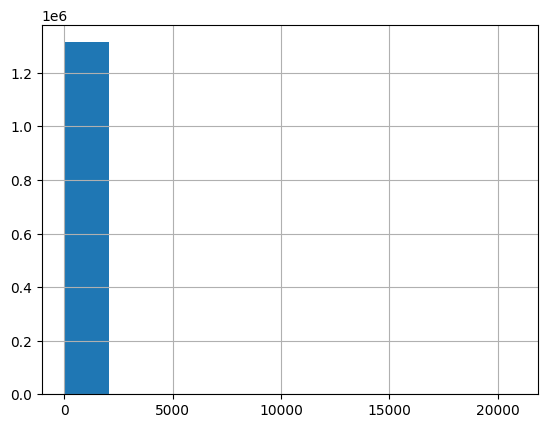

In [33]:
pd.to_numeric(df['residential units'], errors='coerce').hist()

In [34]:
import matplotlib.pyplot as plt

def create_hist_with_filter(data, lt, bins):
    filtered_units = data[data < lt]
    plt.figure(figsize=(12, 6))

    # Plot histogram with better styling
    plt.hist(filtered_units, bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

    plt.ylabel('Frequency', fontsize=12)

    # Add grid for better readability
    plt.grid(axis='y', alpha=0.3)

    # Show plot
    plt.tight_layout()
    plt.show()

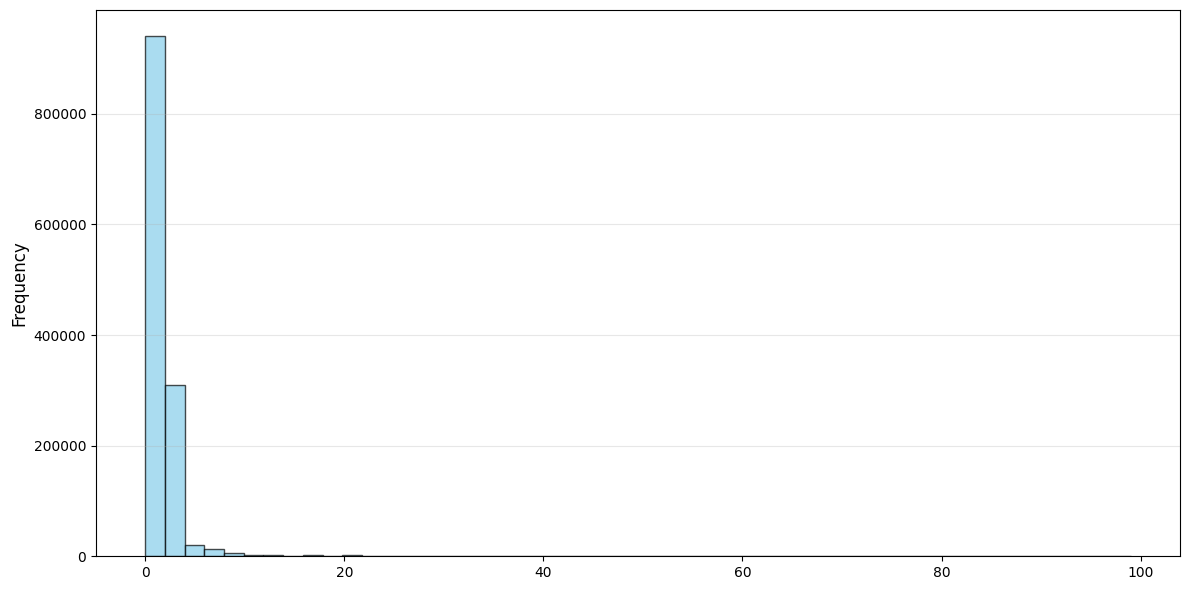

In [35]:
residential_units = pd.to_numeric(df['residential units'], errors='coerce')

create_hist_with_filter(residential_units, 100, 50)

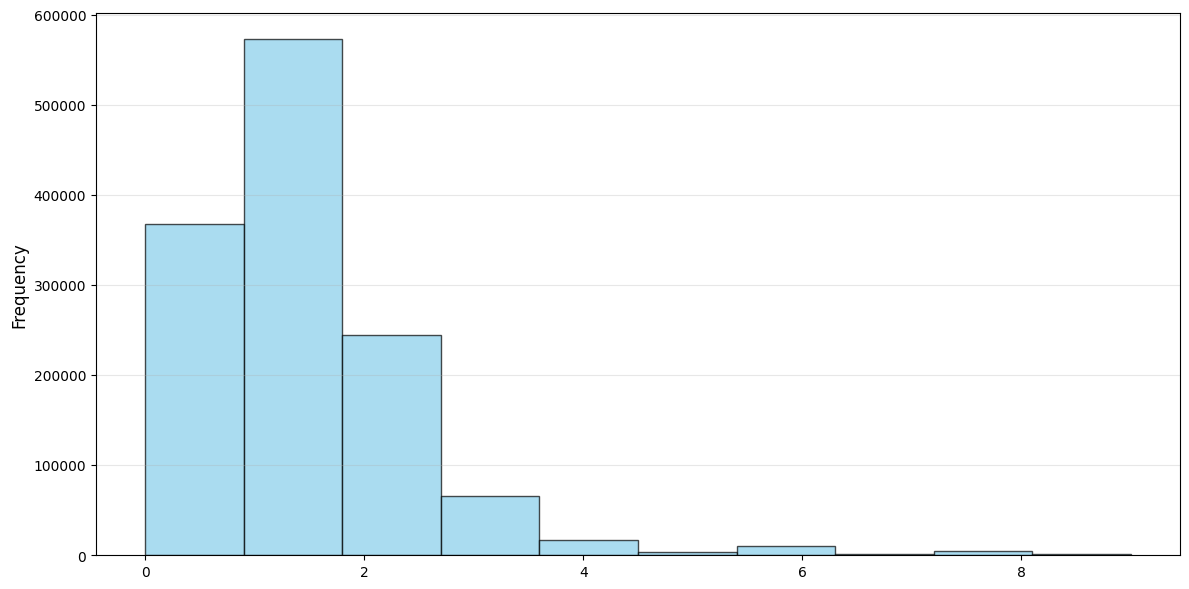

In [36]:
create_hist_with_filter(residential_units, 10, 10)

In [37]:
com_units = pd.to_numeric(df['commercial units'], errors='coerce')
tot_units = pd.to_numeric(df['total units'], errors='coerce')

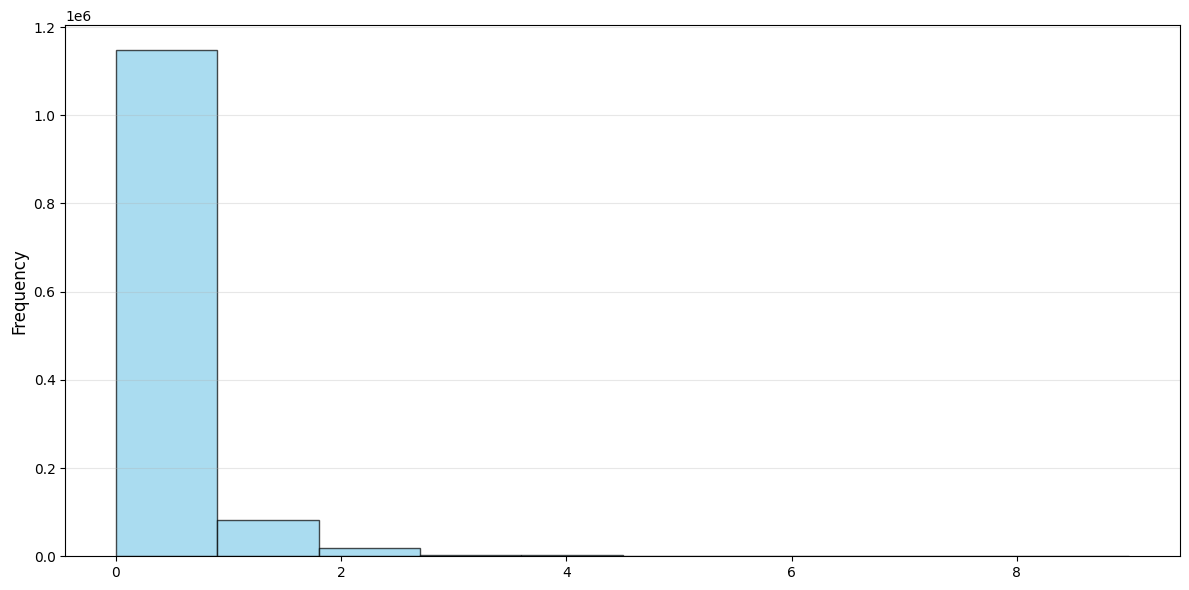

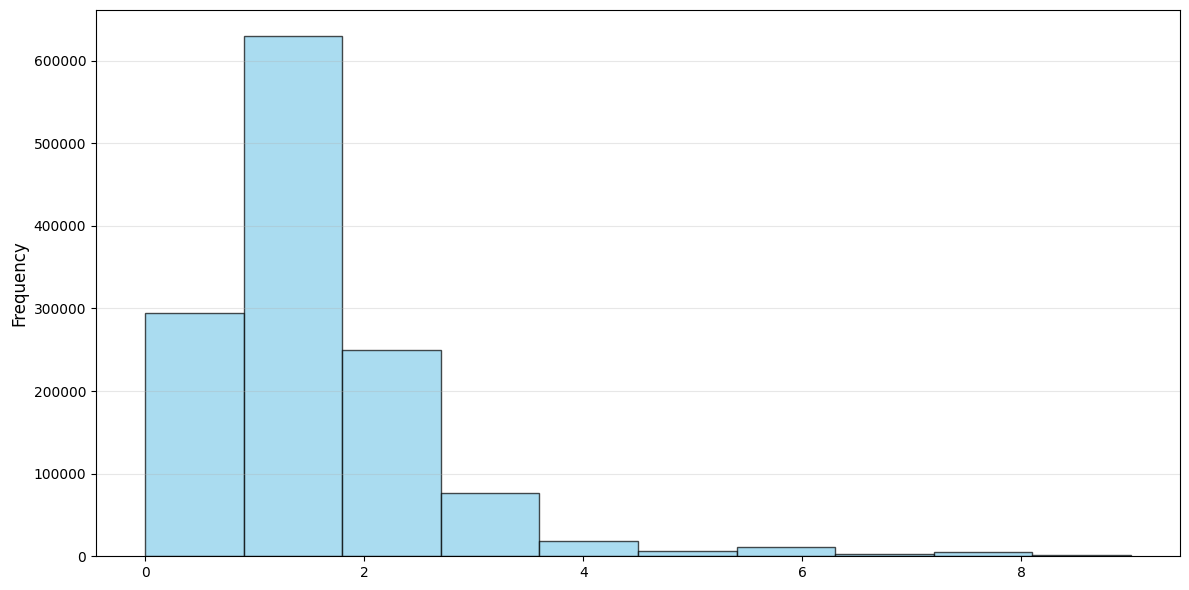

In [38]:
create_hist_with_filter(com_units, 10, 10)
create_hist_with_filter(tot_units, 10, 10)

tutaj proponuje 2 kolumny typu total units i np % udzialu commercial

In [42]:
df["land square feet"] = pd.to_numeric(df['land square feet'], errors='coerce')

In [39]:
pd.to_numeric(df['land square feet'], errors='coerce').value_counts()

land square feet
0.0        525904
2000.0      57625
2500.0      52727
4000.0      43280
3000.0      19079
            ...  
26325.0         1
10485.0         1
72290.0         1
46326.0         1
42278.0         1
Name: count, Length: 17427, dtype: int64

bardzo duzo 0 w powierzchni - moze uzupelnic innym zbiorem?

In [40]:
pd.to_numeric(df['gross square feet'], errors='coerce').value_counts()

gross square feet
0.0         542335
112850.0      7310
2400.0        5931
1600.0        5204
1800.0        5141
             ...  
14946.0          1
27869.0          1
8094.0           1
49041.0          1
10018.0          1
Name: count, Length: 19670, dtype: int64

to samo

<Axes: >

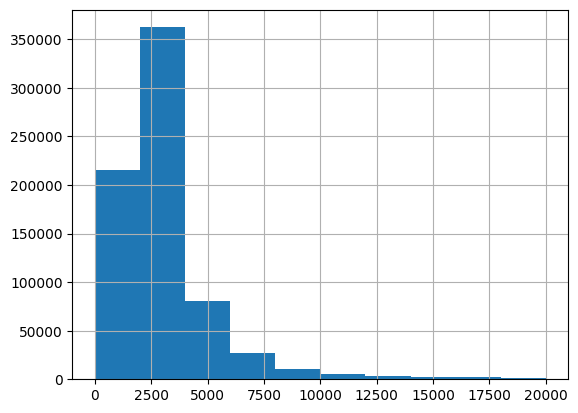

In [43]:
df[(df["land square feet"] != 0) & (df["land square feet"] <= 20000)]["land square feet"].hist()

In [ ]:
df["year built"].value_counts()

year built
0.0       171899
1920.0    147059
1930.0    120413
1925.0    104071
1910.0     82081
           ...  
1842           1
1869           1
1821.0         1
1030.0         1
1841           1
Name: count, Length: 502, dtype: int64

tez duzo pustych niestety

In [44]:
df["year built"] = pd.to_numeric(df['year built'], errors='coerce')

<Axes: >

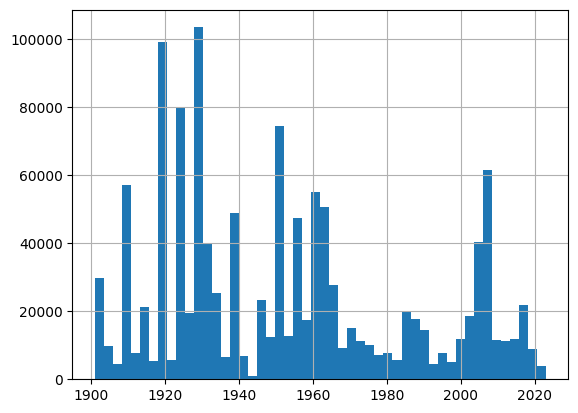

In [53]:
df[df["year built"]>1900]["year built"].hist(bins=50)

tutaj chyba fajnie rozlozone lata jak juz sa - moga duzo mowic

In [56]:
df["tax class at time of sale"].value_counts()

tax class at time of sale
2    671119
1    624426
4     97847
2     15229
1      7603
4      1274
3        67
Name: count, dtype: int64

to chyba spoko - bez przerabiania

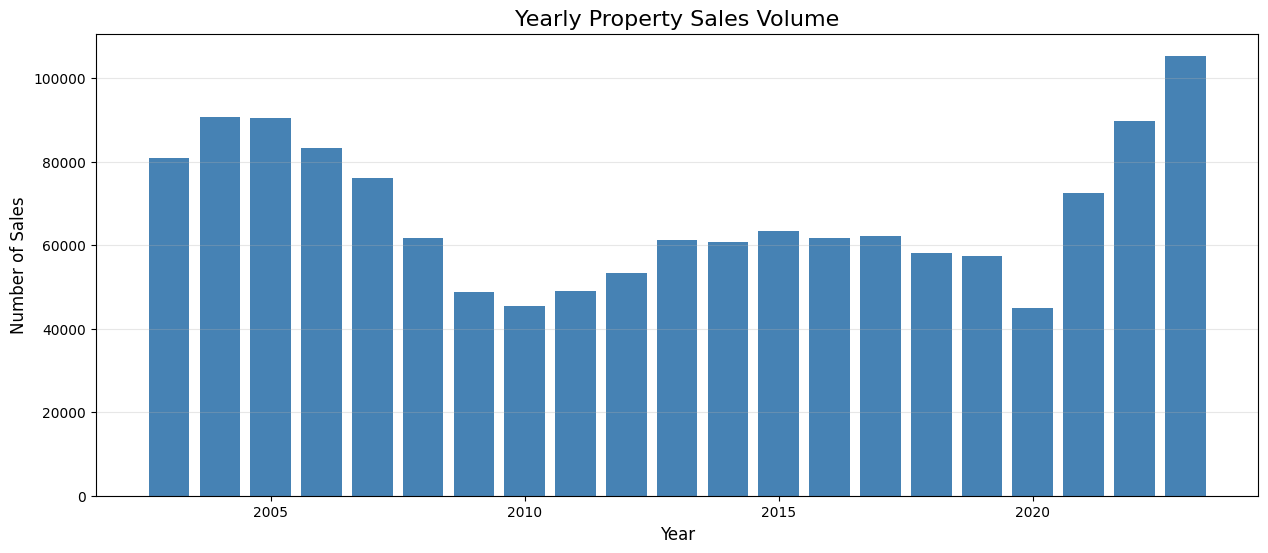

In [66]:
# Convert sale date to datetime if not already done
df["sale_date"] = pd.to_datetime(df["sale date"])

# Create yearly and monthly aggregations for different views
yearly_sales = df.groupby(df["sale_date"].dt.year)["sale_date"].count()
monthly_sales = df.groupby(pd.Grouper(key="sale_date", freq="M"))["sale_date"].count()

# Set up the figure with subplots for yearly and recent monthly trends
fig, ax1 = plt.subplots(1, 1, figsize=(15, 6))

# Plot yearly trend (all data)
ax1.bar(yearly_sales.index, yearly_sales.values, color='steelblue')
ax1.set_title("Yearly Property Sales Volume", fontsize=16)
ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Number of Sales", fontsize=12)
ax1.grid(axis='y', alpha=0.3)

to tez fajne, w miare dobrze porozkladane

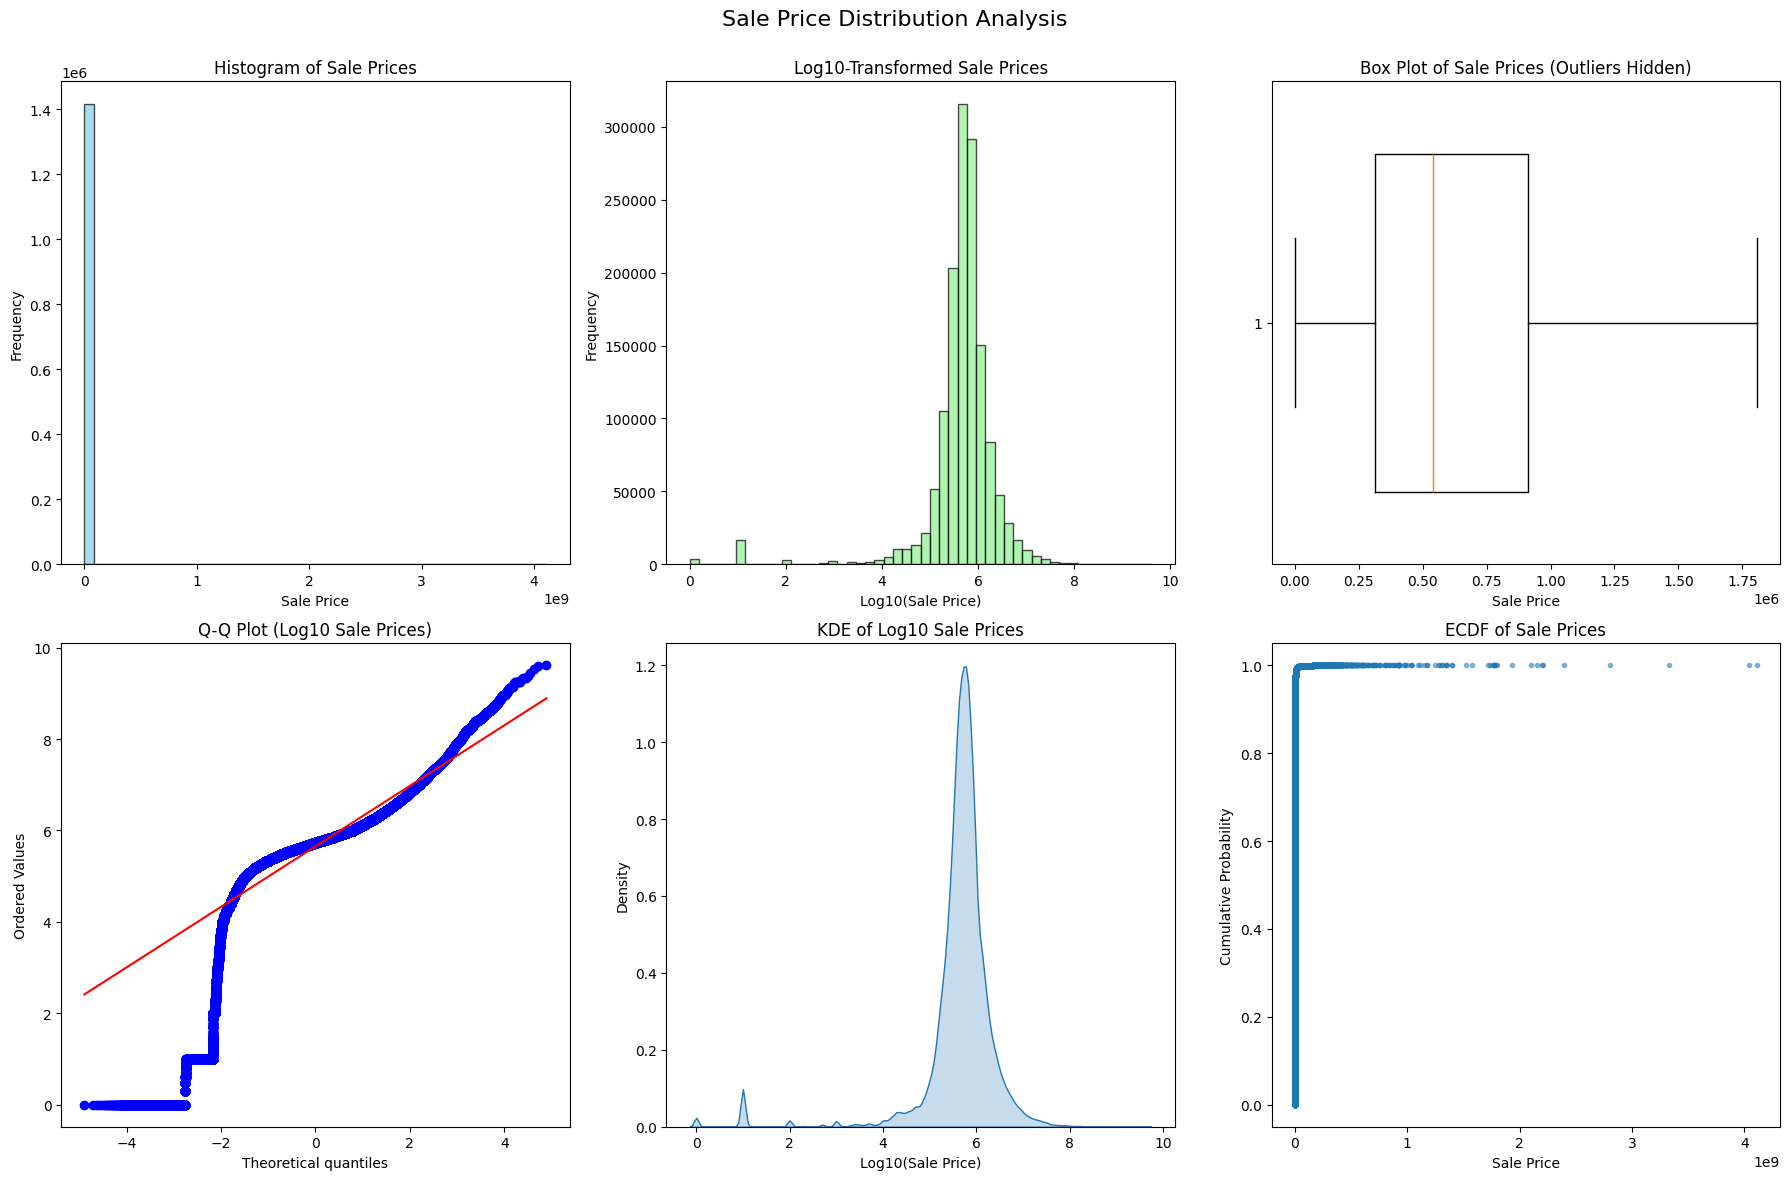

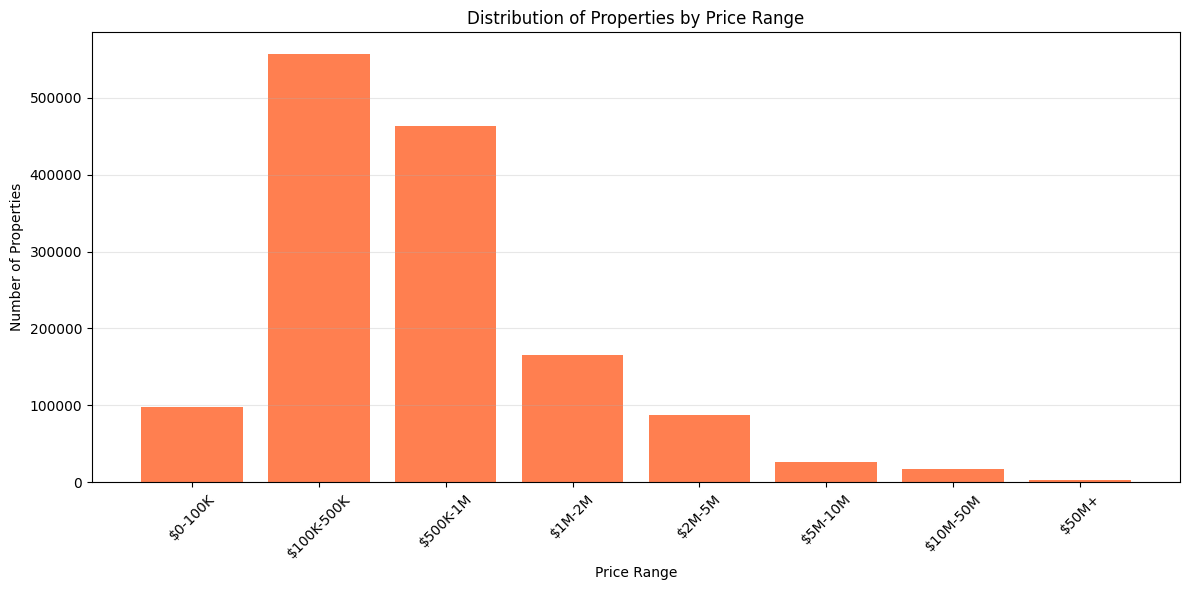

In [82]:
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

# Set up the figure with multiple plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Sale Price Distribution Analysis', fontsize=16)

# Filter out zero or negative values
filtered_prices = df_renamed[df_renamed["SALE PRICE"] > 0]["SALE PRICE"]

# 1. Histogram
axes[0, 0].hist(filtered_prices, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Histogram of Sale Prices')
axes[0, 0].set_xlabel('Sale Price')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# 2. Log-transformed histogram
axes[0, 1].hist(np.log10(filtered_prices), bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Log10-Transformed Sale Prices')
axes[0, 1].set_xlabel('Log10(Sale Price)')
axes[0, 1].set_ylabel('Frequency')

# 3. Box plot - hide outliers by setting showfliers=False
axes[0, 2].boxplot(filtered_prices, vert=False, widths=0.7, showfliers=False)
axes[0, 2].set_title('Box Plot of Sale Prices (Outliers Hidden)')
axes[0, 2].set_xlabel('Sale Price')
axes[0, 2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# 4. Q-Q plot
qq = stats.probplot(np.log10(filtered_prices), plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Log10 Sale Prices)')

# 5. Kernel Density Estimation
sns.kdeplot(np.log10(filtered_prices), ax=axes[1, 1], fill=True)
axes[1, 1].set_title('KDE of Log10 Sale Prices')
axes[1, 1].set_xlabel('Log10(Sale Price)')
axes[1, 1].set_ylabel('Density')

# 6. ECDF (Empirical Cumulative Distribution Function)
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y

x, y = ecdf(filtered_prices)
axes[1, 2].plot(x, y, marker='.', linestyle='none', alpha=0.5)
axes[1, 2].set_title('ECDF of Sale Prices')
axes[1, 2].set_xlabel('Sale Price')
axes[1, 2].set_ylabel('Cumulative Probability')
axes[1, 2].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# Additional plot for price range distribution
plt.figure(figsize=(12, 6))

# Define price ranges
price_ranges = [
    (0, 1e5), (1e5, 5e5), (5e5, 1e6), (1e6, 2e6), 
    (2e6, 5e6), (5e6, 1e7), (1e7, 5e7), (5e7, np.inf)
]
labels = [
    '$0-100K', '$100K-500K', '$500K-1M', '$1M-2M',
    '$2M-5M', '$5M-10M', '$10M-50M', '$50M+'
]

# Count properties in each range
counts = []
for lower, upper in price_ranges:
    count = len(filtered_prices[(filtered_prices >= lower) & (filtered_prices < upper)])
    counts.append(count)

# Plot bar chart
plt.bar(labels, counts, color='coral')
plt.title('Distribution of Properties by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

widac troche outlierow ale ogolnie to chyba w miare w porzadku, nadal jest troche niskich wartosci oraz przez te skrajne ciezko przeczytac niektore wykresy - transformacja logarytmiczna fajna bo mamy prawie rozklad normalny